In [27]:
# imports and paths
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import os

# defining file name
RATINGS = "ratings.csv"
MOVIES  = "movies.csv"
TAGS    = "tags.csv"
LINKS   = "links.csv"


In [28]:
# Importing files
from google.colab import files
uploaded = files.upload()


Saving links.csv to links (1).csv
Saving movies.csv to movies (1).csv
Saving ratings.csv to ratings (1).csv
Saving tags.csv to tags (1).csv


In [29]:
#checking files are in the currrent folder
import os
print(os.listdir())

['.config', 'movies.csv', 'movies (1).csv', 'links (1).csv', 'tags.csv', 'links.csv', 'movies_ratings_cleaned.csv', 'tags (1).csv', 'ratings (1).csv', 'ratings.csv', 'sample_data']


In [30]:
# load data and preview dataset
def safe_read(fn):
    if not os.path.exists(fn):
        print(f"WARNING: {fn} not found in working dir.")
        return None
    return pd.read_csv(fn)

ratings = safe_read(RATINGS)
movies  = safe_read(MOVIES)
tags    = safe_read(TAGS)
links   = safe_read(LINKS)

for name, df in [("ratings", ratings), ("movies", movies), ("tags", tags), ("links", links)]:
    if df is not None:
        print(name, "shape:", df.shape)
        display(df.head(2))


ratings shape: (100836, 4)


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247


movies shape: (9742, 3)


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy


tags shape: (3683, 4)


,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996


links shape: (9742, 3)


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0


In [31]:
# Merge ratings and movies
df = ratings.merge(movies, on='movieId', how='left')


In [32]:
# Merge with tags and links
df = df.merge(links, on='movieId', how='left')
df['rating_datetime'] = pd.to_datetime(df['timestamp'], unit='s')
print("Merged df shape:", df.shape)
display(df.head())

Merged df shape: (100836, 9)


,userId,movieId,rating,timestamp,title,genres,imdbId,tmdbId,rating_datetime
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0,2000-07-30 18:45:03
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance,113228,15602.0,2000-07-30 18:20:47
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller,113277,949.0,2000-07-30 18:37:04
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,114369,807.0,2000-07-30 19:03:35
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,114814,629.0,2000-07-30 18:48:51


In [33]:
# Checking for duplicates and missing values
print("Duplicates (full rows):", df.duplicated().sum())
print("Missing values per column:")
display(df.isnull().sum())

Duplicates (full rows): 0
Missing values per column:


,0
userId,0
movieId,0
rating,0
timestamp,0
title,0
genres,0
imdbId,0
tmdbId,13
rating_datetime,0


In [34]:
# converting timestamp to datetime
if 'timestamp' in df.columns:
    df['rating_datetime'] = pd.to_datetime(df['timestamp'], unit='s', errors='coerce')


In [35]:
# Feature Engineering

#1. Extract release year from title
import re
def extract_year(title):
    m = re.search(r'\((\d{4})\)\s*$', str(title))
    return int(m.group(1)) if m else np.nan

df['release_year'] = df['title'].apply(extract_year)


In [36]:
#2. Movie age at rating

df['rating_year'] = df['rating_datetime'].dt.year
df['movie_age_at_rating'] = df['rating_year'] - df['release_year']

display(df[['title', 'rating_year', 'release_year', 'movie_age_at_rating']].head())

,title,rating_year,release_year,movie_age_at_rating
0,Toy Story (1995),2000,1995.0,5.0
1,Grumpier Old Men (1995),2000,1995.0,5.0
2,Heat (1995),2000,1995.0,5.0
3,Seven (a.k.a. Se7en) (1995),2000,1995.0,5.0
4,"Usual Suspects, The (1995)",2000,1995.0,5.0


In [37]:
#3. Number of genres
df['num_genres'] = df['genres'].fillna('(no genres listed)').apply(lambda x: 0 if x == '(no genres listed)' else len(x.split('|')))


In [38]:
#4. One-Hot Encode Movie Genres
df['genres'] = df['genres'].fillna('')
genre_dummies = df['genres'].str.get_dummies(sep='|')
df = pd.concat([df, genre_dummies.add_prefix('genre_')], axis=1)


In [39]:
#5. User mean rating (user behavior feature)
user_mean_rating = ratings.groupby('userId')['rating'].mean().rename('user_mean_rating')
df = df.merge(user_mean_rating, on='userId', how='left')


In [40]:
#6. Days since rating
df['rating_date'] = df['rating_datetime'].dt.date
df['days_since_rating'] = (pd.Timestamp.today().normalize() - pd.to_datetime(df['rating_date'])).dt.days


In [41]:
#7. Decade
df['decade'] = (df['release_year'] // 10 * 10).astype('Int64')


In [42]:
#8. Tag count per movie
if tags is not None:
    tag_counts = tags.groupby('movieId').size().rename('tag_count')
    df = df.merge(tag_counts, on='movieId', how='left').fillna({'tag_count': 0})

In [43]:
# export cleaned dataset
out = "movies_ratings_cleaned.csv"
df.to_csv(out, index=False)
print("Saved cleaned dataset to", out)


Saved cleaned dataset to movies_ratings_cleaned.csv


In [44]:
from google.colab import files

# Download the CSV file
files.download("movies_ratings_cleaned.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

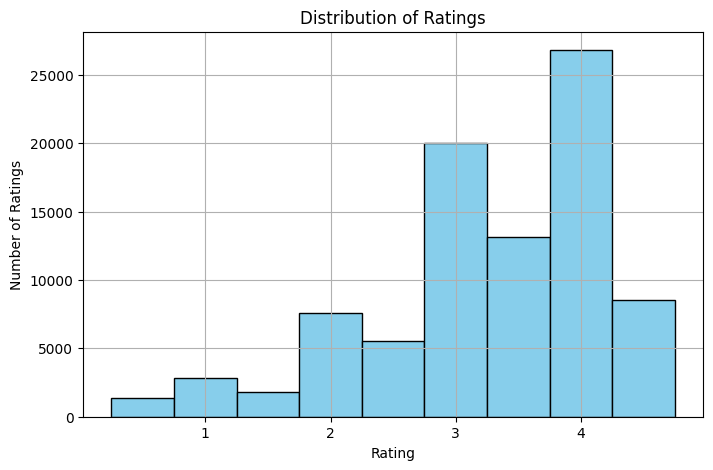

In [45]:
# Exploratory Data Analysis


# 1. Distribution Rating
plt.figure(figsize=(8,5))
plt.hist(df['rating'].dropna(), bins=np.arange(0.25, 5.25, 0.5), color='skyblue', edgecolor='black')
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Number of Ratings")
plt.grid(True)
plt.show()


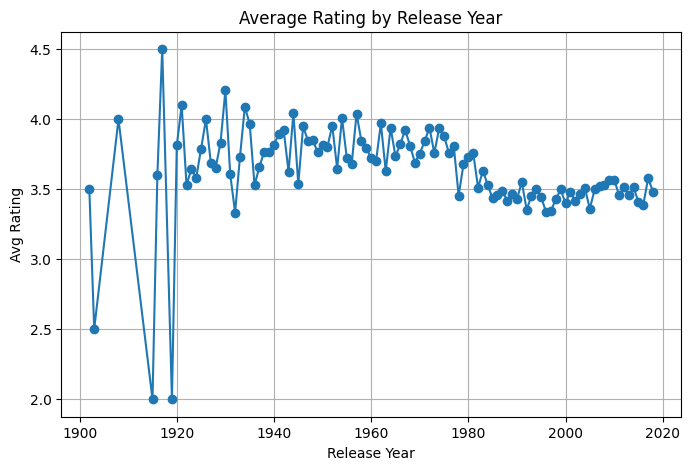

In [46]:
#2. Rating Trend by Release Year

yearly = df.groupby('release_year')['rating'].mean().dropna()
plt.figure(figsize=(8,5))
plt.plot(yearly.index, yearly.values, marker='o')
plt.title("Average Rating by Release Year")
plt.xlabel("Release Year")
plt.ylabel("Avg Rating")
plt.grid(True)
plt.show()


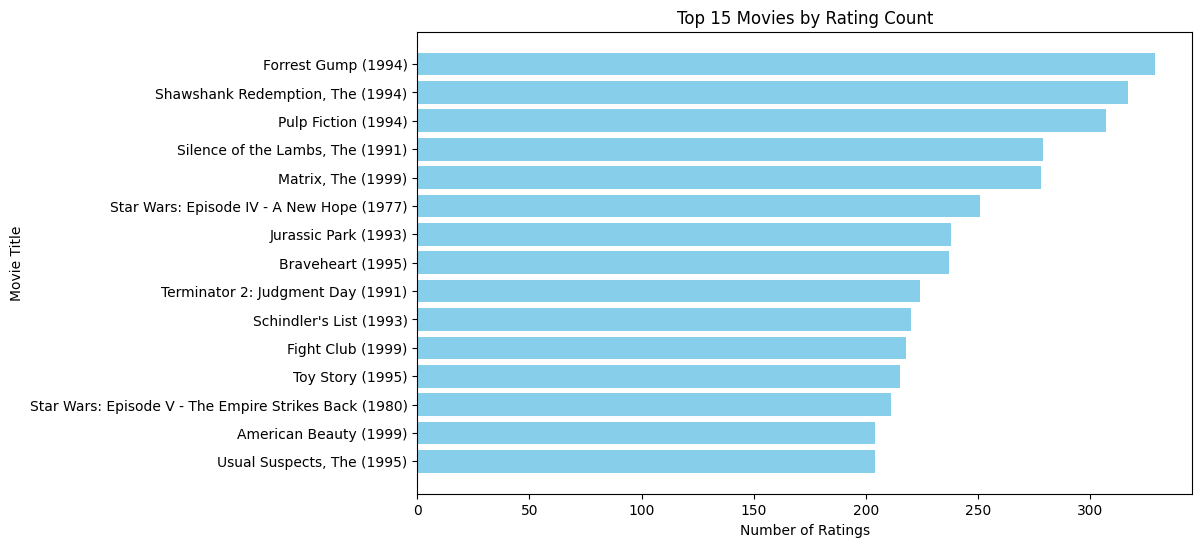

In [47]:
#3. Top 15 Movies by Rating Count

movie_stats = df.groupby('movieId').agg(rating_count=('rating', 'count'))
top = movie_stats.sort_values('rating_count', ascending=False).head(15)
top_with_titles = top.merge(df[['movieId','title']].drop_duplicates(), on='movieId', how='left')
plt.figure(figsize=(10,6))
plt.barh(top_with_titles['title'], top_with_titles['rating_count'], color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel("Number of Ratings")
plt.ylabel("Movie Title")
plt.title("Top 15 Movies by Rating Count")
plt.show()

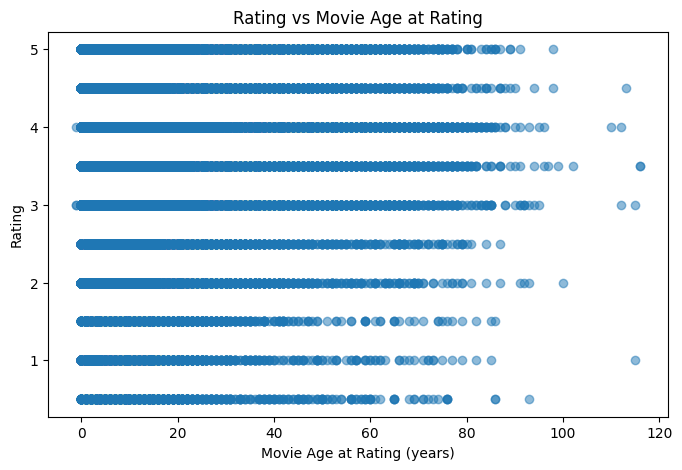

In [48]:
#4. Rating vs Movie Age

df_plot = df.dropna(subset=['movie_age_at_rating', 'rating'])
plt.figure(figsize=(8,5))
plt.scatter(df_plot['movie_age_at_rating'], df_plot['rating'], alpha=0.5)
plt.xlabel("Movie Age at Rating (years)")
plt.ylabel("Rating")
plt.title("Rating vs Movie Age at Rating")
plt.show()


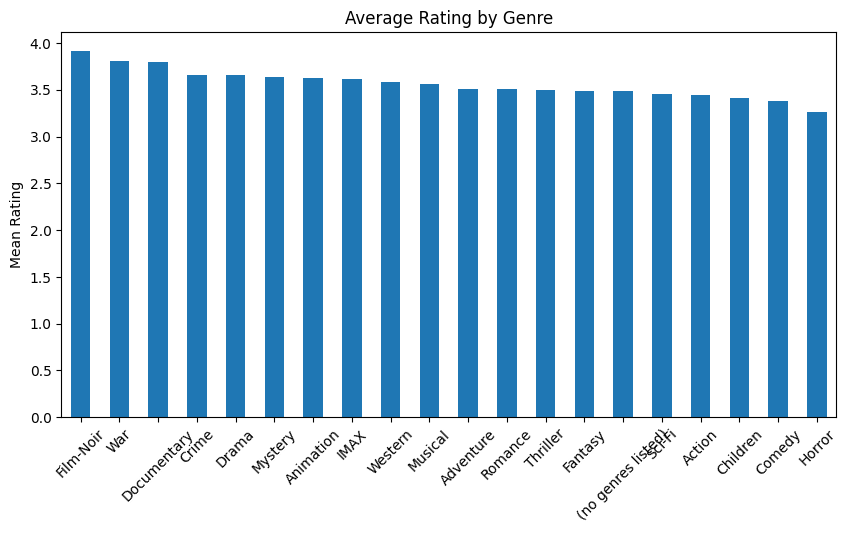

In [49]:
#5. Average Rating by Genre

genre_cols = [c for c in df.columns if c.startswith('genre_')]
genre_avg = {g.replace('genre_', ''): df.loc[df[g]==1, 'rating'].mean() for g in genre_cols}
pd.Series(genre_avg).sort_values(ascending=False).plot(kind='bar', figsize=(10,5))
plt.title("Average Rating by Genre")
plt.ylabel("Mean Rating")
plt.xticks(rotation=45)
plt.show()


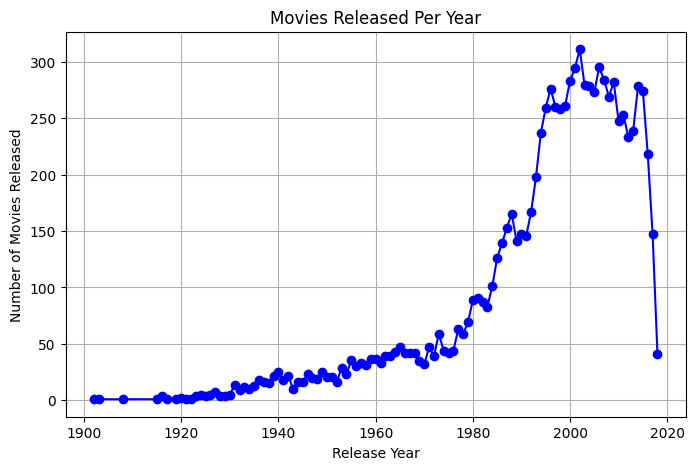

In [56]:
#6. Number of Movies Released per Year

movies_per_year = df.groupby('release_year')['movieId'].nunique()
plt.figure(figsize=(8,5))
plt.plot(movies_per_year.index, movies_per_year.values, marker='o', color='Blue')
plt.title("Movies Released Per Year")
plt.xlabel("Release Year")
plt.ylabel("Number of Movies Released")
plt.grid(True)
plt.show()


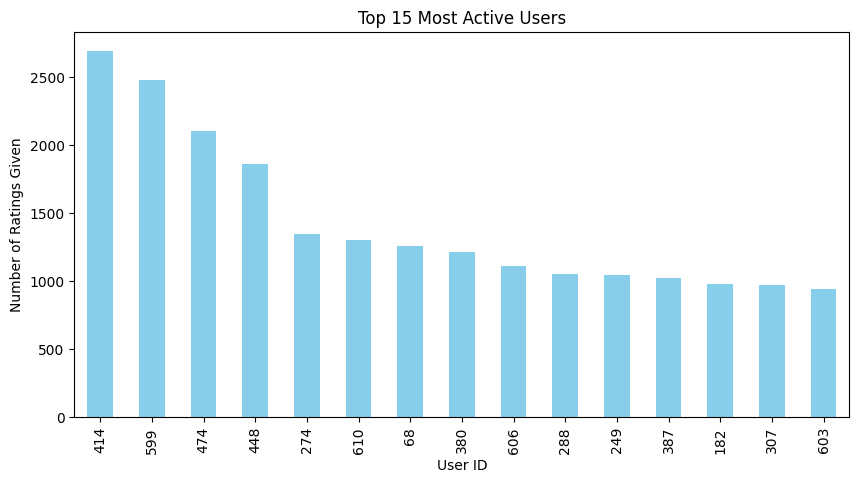

In [58]:
#7. Top 15 Most Active Users

top_users = df['userId'].value_counts().head(15)
top_users.plot(kind='bar', color='skyblue', figsize=(10,5))
plt.title("Top 15 Most Active Users")
plt.xlabel("User ID")
plt.ylabel("Number of Ratings Given")
plt.show()
